<h1><center>MLSMM2155 Systeme de Recommandation</center></h1>
<h2><center> Dubois Zoe - 22181600 </center></h1>
<h2><center> Hautecourt Romain - 22611600 </center></h1>
<h3><center> Professeur : Felix Sommer </center></h1>
<h3><center>Juin 2020<h1><center>

# Table des matières
- 1. Introduction générale
- 2. Présentation des bases de données
    - 2.1 MovieLens
    - 2.2 Jester
    - 2.3 Votre choix
- 3. Cross-validation
- 4. Présentation des 4 approches
    - 4.1 Moyennes
    - 4.2 Présentation de Pearson et Cosine
    - 4.3 Modèle des facteurs latents
- 5. Mesures d'évaluations des systèmes
- 6. Lancement des différents systèmes avec une cross-validation
- 7. Comparaison de nos systèmes
- 8. Conclusion

# 1. Introduction générale.

Dans le cadre de ce travail, nous allons implémenter et évaluer plusieurs systèmes de recommandations. Pour ce faire, nous aurons recours à deux bases de données : MovieLens et Jester. 
Un système de recommandation est un système qui suggère des actions à prendre concernant un individu. Il s’agit aussi d’un système de prédiction des préférences des utilisateurs pour des objets non préalablement testés. Un système de recommandation se construit sur base de l’historique de l’utilisateur ou de l’objet, item.
Sur Netflix, par exemple, le système étudie ce que l’utilisateur a déjà regardé et apprécié (grâce à la note attribuée au film) et suggère des films que d’autres utilisateurs ayant de goûts similaires, ont regardé. Ces systèmes de recommandations sont également largement utilisés sur les sites Amazon, LinkedIn, Facebook. 

Les systèmes de recommandations sont basés sur les préférences explicites ou implicites des utilisateurs. Les préférences implicites sont récoltées en observant les actions des utilisateurs. Par exemple, il peut s’agir d’observer les clicks sur le net ou les achats fait dans un magasin. Les feedback explicites sont, quant à eux, récoltés en interagissant directement avec les utilisateurs. Nous les utiliserons dans ce travail, via les ratings ou évaluations laissés par des utilisateurs au sujet d’item c’est-à-dire un film pour MovieLens et une blague pour Jester. 

Dans le cadre de ce travail, nous présenterons et évaluerons, grâce à des mesures telles que l’erreur moyenne absolue, différents systèmes de recommandations tel que:
1.	  <em>Averages</em> : Pour prédire les ratings d’un user (ou item), nous allons implémenter un système qui prend en compte la moyenne des ratings laissées en général par ce dernier. Une autre approche plus naïve consisterait à simplement prendre la moyenne de tous les ratings. Prédire le rating d’un utilisateur au sujet d’un item en lui attribuant la valeur moyenne de tous les ratings de la base de données d’entraînement.
2.	 <em>Collaborative Filtering</em> : Cette approche, appelée Collaborative filtering en anglais, permet de prédire le rating d’un utilisateur (ou item) au sujet d’un item via les ratings que ces voisins les plus proches ont laissés pour cet item.
3.	 <em>Matrix Factorization</em> : Ce modèle permet de prédire n’importe quelle évaluation d’un film par un utilisateur grâce à 2 matrices de facteurs latents : une basée sur l’utilisateur et l’autre basée sur l’item.


Nous commençons pour le téléchargement de quelques packages qui nous seront utile au cours de l’élaboration de ce projet [Code 1].


In [1]:
## Code 1 : Téléchargement des packages
import pandas as pd
import numpy as np
from numpy import save
from numpy import load
import math
import matplotlib
import statistics

from scipy import sparse
from scipy.stats import uniform
from IPython.display import Latex
import collections
from operator import itemgetter

import sklearn
from scipy import spatial
from sklearn.metrics import pairwise_distances
from scipy.spatial.distance import cosine, correlation

# 2. Présentation des bases de données
## 2.1 MovieLens

La première base donnée utilisée est nommée « ratings » et a été mise en ligne par le site movielens.org. Elle contient un total de 100 004 ratings attribué par 671 utilisateurs sur 9 066 films entre janvier 1995 et octobre 2016. Une troisième colonne permet, d’ailleurs, de retrouver le moment auquel l’évaluation du film a été laissée sur la plateforme. Chaque utilisateur, qui a évalué au moins 20 films sur le site imdb.com, et chaque film est identifié par un identifiant appelé respectivement userId et movieId. On notera également que les évaluations de films sont des valeurs comprises entre 0.5 et 5 et que les identifiants maximums des utilisateurs et des films valent respectivement 671 et 163 949.

D’autres bases de données sont associées à celles utilisés dans ce travail. On retrouve, par exemple, des informations sur les titres des films, leur genre, leur IMDB permettant d’identifier un film ou encore des tags, mot ou groupe de mot, laissé par des utilisateurs. Toutefois, ces bases de données ne feront pas l’objet d’une analyse plus approfondie dans le cadre de ce travail. 

Nous avons adapté la matrice de données de départ pour lui donner un format le plus standard possible [Code 2]. Nous avons renommé la colonne movieId en itemId et supprimé la colonne timetstamp. De plus, comme certains itemId n’ont pas de ratings et ne feront, dès lors, pas l’objet d’une prédiction, nous avons réduit et converti les identifiants en une série de nombres compris entre 1 et 9 066 (et plus entre 1 et 163 949). La correspondance entre les anciens et les nouveaux identifiants peut être retrouvée très aisément grâce au vecteur « number_movieid_ini » qui contient les anciens identifiants classés de manière croissante. Cela nous permettrait, notamment, de créer facilement des matrices de facteurs latents d’une taille plus raisonnable (voir section n°4 sur les systèmes de recommandation).



In [2]:
####### Code 2 : Chargement de MovieLens
full_data_ini = pd.read_csv('ratings.csv',sep=";")
full_data_ini=full_data_ini.drop(columns='timestamp') 
full_data_ini.columns =["userId", "itemId", "rating"]

number_userid_ini=np.unique(full_data_ini.iloc[:,0])## reprend 1x les users id qui apparaissent dans full_data par ordre croissant
print('Nombre total utilisateurs ' +str(number_userid_ini.shape) + ' et le userId maximum au début ' +str(number_userid_ini[670]))

number_movieid_ini=np.unique(full_data_ini.iloc[:,1])## reprend 1x les movie id qui apparaissent dans full_data par ordre croissant
print('Nombre total films ' +str(number_movieid_ini.shape) + ' et le movieId maximum au début ' +str(number_movieid_ini[9065]))
for i in range (number_movieid_ini.shape[0]):
    full_data_ini.iloc[:,1]=full_data_ini.iloc[:,1].replace(number_movieid_ini[i],i+1) ## remplace chaque itemId par sa position+1 dans la matrice number_movieid_ini
print('Maintenant, le movieId maximum est ' +str(max(full_data_ini["itemId"])))
    
full_data1 = full_data_ini
print('\n' + str(full_data1))

Nombre total utilisateurs (671,) et le userId maximum au début 671
Nombre total films (9066,) et le movieId maximum au début 163949
Maintenant, le movieId maximum est 9066

        userId  itemId  rating
0            1    1666     4.0
1            1    1516     4.0
2            1     932     4.0
3            1    1084     3.5
4            1    2926     3.0
...        ...     ...     ...
99999      671    4000     2.0
100000     671    3883     2.0
100001     671    3114     2.0
100002     671    2781     2.0
100003     671    2454     1.0

[100004 rows x 3 columns]


Certains systèmes de recommandations, prennent en entrée une matrice R dite user-item, où chaque utilisateur est représenté par une ligne et chaque item par une colonne. C’est le cas, par exemple, des systèmes user-based et item-based implémentés grâce au calcul de similarité (voir section n°4). Dès lors, nous avons créé une autre version de la base de données où, de nouveau, les identifiants des utilisateurs ont été réduits à maximum 9 066. [Code2].


In [3]:
####### Code 3: transformation en matrice user-item
data_matrix1=full_data1.pivot_table(index = "userId",columns = "itemId",values = 'rating')
data_matrix1.fillna(0,inplace=True) # matrice user-item

-------------------------------------------------------------------------
## 2.2 Jester
La deuxième base de données, JesterData, recense l’évaluation de 158 blagues réalisée par 7 699 utilisateurs entre avril 2015 et novembre 2019 sur Jester. Cette matrice possède la forme user-item où chaque utilisateur et chaque blague est représenté respectivement par une ligne et une colonne. Toutefois, la première colonne de la matrice est dédiée au nombre d’évaluation rendue par chaque utilisateur. L’évaluation d’une blague par un utilisateur est un nombre entier entre -10 et 10. Si l’utilisateur n’a pas évalué la blague, l’évaluation vaut 99. D’ailleurs, 22 blagues ne possèdent pas de ratings. De plus, nous constatons que certains ratings dit aberrants ne sont compris ni dans cet intervalle ni égaux à 99. 

Dans un premier temps, nous avons effectué quelques modifications sur cette base de données [Code 4]. Tous les ratings égaux à 0 ont été remplacés par 0.01. Les valeurs aberrantes, non comprises dans l’intervalle de -10 à 10 et non égales à 99 ont été remplacées par -10 si elles étaient négatives et par 10 si elles étaient positives. Nous avons fait l’hypothèse que certains utilisateurs ont pu oublier les consignes et encoder de mauvaises valeurs. 

Nous constatons que la matrice user-item est dite sparse. Cela signifie qu’elle est en grande partie vide. Pour réduire l’espace de stockage nécessaire et fusionner la mise en forme de la matrice avec celle faite pour MovieLens, nous avons modifié cette deuxième matrice user-item. La première colonne a été remplacée par des chiffres de 0 à 7 699 représentants les identifiants des utilisateurs. Nous avons de manière plus générale attribué une ligne à chaque rating effectivement donné, différent de 99 et de 0. L’identifiant de l’utilisateur et de la blague associée se trouve dans la colonne 1 et 2, alors que le rating est placé dans le troisième colonne. Nous voulions donc avoir le même format initial que MovieLens, c’est-à-dire,  par exemple:

| userId | itemId | rating |
| --- | --- | --- |
|1  | 1  | 5 |




In [4]:
####### Code 4 : Chargement de Jester

datas = pd.read_csv('JesterData.csv',sep=";",header=None,decimal=',')
datas=datas.rename(columns={0:"userId"})
for i in range (7699):
    datas.iloc[i,0]=i
datas=datas.replace(0.00,0.01)
data=pd.melt(datas,id_vars='userId',var_name='itemId',value_name='rating')
data['itemId'] = data.itemId.astype(int)
data['rating'] = data.rating.astype(float)
data=data.drop(data[data['rating']==99].index)

datas=data.pivot_table(index="userId",columns="itemId",values="rating")
datas.fillna(0,inplace=True)

id=[]
for i in range (1,137):
    id.append(i)
datas.columns=id
datas=datas.rename_axis("itemId",axis="columns")

id=[]
for i in range (7699):
    id.append(i)
datas.insert(0, "userId", id,)

data=pd.melt(datas,id_vars='userId',var_name='itemId',value_name='rating')
data['itemId'] = data.itemId.astype(int)
data['rating'] = data.rating.astype(float)

data=data.drop(data[data['rating']==0].index)
data =data.sample(frac=1).reset_index(drop=True)

print('Certains ratings possèdent des valeures abérrantes, plus petite que -10 ou plus grande que 10. En effet, le rating maximum est ' + str (max(data["rating"])) + ', le minimum est ' +  str (min(data["rating"])))
data['rating'].values[data['rating'].values > 10] = 10
data['rating'].values[data['rating'].values < -10] = -10
print('On a retiré les valeurs abérrantes. Maintenant, le rating maximum est ' + str (max(data["rating"])) + ', le minimum est ' +  str (min(data["rating"])))
full_data2=data
data_matrix2=datas

Certains ratings possèdent des valeures abérrantes, plus petite que -10 ou plus grande que 10. En effet, le rating maximum est 28.58, le minimum est -42.28
On a retiré les valeurs abérrantes. Maintenant, le rating maximum est 10.0, le minimum est -10.0


## 2.3 Votre choix
Dans la cellule suivante, nous allons vous demander d'interagir avec le système en choisissant la base de données avec laquelle vous désirez travailler. Lancez la cellule et suivez les instructions.

Pour modifier ultérieurement votre choix, il sera nécessaire de revenir à cette cellule et d’indiquer la base de données désirée et de lancer à nouveaux tous les codes suivants [code 5, code 6, code 35].


In [5]:
######## Code 5 : Faites un choix

choice_dataset=int(input("Nous vous demandons de rentrer le chiffre 1 ou 2: \n si vous voulez une analyse de MovieLens, tapez 1  \n si vous voulez une analyse de Jester, tapez 2 "))

if choice_dataset==1:
    full_data=full_data1
    data_matrix=data_matrix1
    print()
    print("Nous avons bien chargé les données pour MovieLens")
if choice_dataset==2:
    full_data=full_data2
    data_matrix=data_matrix2
    print()
    print("Nous avons bien chargé les données de Jester")


Nous vous demandons de rentrer le chiffre 1 ou 2: 
 si vous voulez une analyse de MovieLens, tapez 1  
 si vous voulez une analyse de Jester, tapez 2  2



Nous avons bien chargé les données de Jester


# 3. Cross validation 


Pour pouvoir entrainer nos systèmes de recommandations et les évaluer par la suite, il est intéressant de réaliser une validation croisée, appelée également cross-validation. Dans le cadre de ce travail, nous avons utilisé une cross-validation « 5-fold » qui a pour réputation d’être assez efficace.

Dans un premier temps, nous avons mélangé toutes les lignes et séparé en 5 bases de données, appelées partitions, distinctes de nos données initiales [Code 6].

In [6]:
####### Code 6 : Split des datas en folds

mix_full_data = full_data.sample(frac=1).reset_index(drop=True)

## Suppose qu'on a déjà connaissance de la forme des 2 bases de données : Ratings 100 004
    
if mix_full_data.shape[0] ==100004:
    print("Vous avez choisi MovieLens!")
    choix=1
    dataset1= mix_full_data.iloc[0:20000,:]
    dataset2= mix_full_data.iloc[20000:40001,:] # ajoute 1 à partir de ce fold
    dataset3= mix_full_data.iloc[40001:60002,:]
    dataset4= mix_full_data.iloc[60002:80003,:]
    dataset5= mix_full_data.iloc[80003:100004,:]

elif  mix_full_data.shape[0] ==106489 :
    print("Vous avez choisi Jester!")
    choix=2
    dataset1= mix_full_data.iloc[0:21297,:]
    dataset2= mix_full_data.iloc[21298:42596,:] # ajoute 1 à partir de ce fold
    dataset3= mix_full_data.iloc[42597:63895,:]
    dataset4= mix_full_data.iloc[63896:85194,:]
    dataset5= mix_full_data.iloc[85191:106489,:]

Vous avez choisi Jester!


Il s’agit ensuite d’entraîner les systèmes de recommandations sur 80% de la base de données initiale et de le tester sur les 20% restants. Cette opération est répétée à cinq reprises pour permettre à chaque partition définie plus haut d’être utilisée pour le test. 

Ci-dessous se trouve le code 7a et 7b qui permettent, respectivement, de constituer la base de données d’entraînement et de test, appelée train et test set, sur base des partitions réalisées plus haut. Pour chacune des 5 itérations représentées par la valeur de z, nous entraînerons nos modèles et les testerons ultérieurement [section 6 code 38]

In [7]:
####### Code 7a : Création du trainset
def Choose_trainset(z):
    trainset=0
    if z==1:
        trainset=dataset1.append(dataset2).append(dataset3).append(dataset4)
    elif z==2:
        trainset=dataset2.append(dataset3).append(dataset4).append(dataset5)
    elif z==3:
        trainset=dataset3.append(dataset4).append(dataset5).append(dataset1)
    elif z==4:
        trainset=dataset4.append(dataset5).append(dataset1).append(dataset2)
    elif z==5:
        trainset=dataset5.append(dataset1).append(dataset2).append(dataset3)
    return trainset

In [8]:
####### Code 7b : Création du testset

def Choose_testset(z):
    testset=0
    if z==1:
        testset=dataset5
    elif z==2:
        testset=dataset1
    elif z==3:
        testset=dataset2
    elif z==4:
        testset=dataset3
    elif z==5:
        testset=dataset4
    return testset

# 4. Présentation de systèmes de recommandation 
Voici, un bref aperçu des systèmes de recommandations implémentés sur chacune des bases de données. Chacun d’eux sera expliqué de manière plus approfondie et détaillé juste après.

||MovieLens|Jester|
|---|---|---|
|Moyenne de la base de données|$$\bullet$$|$$\bullet$$|
|Moyenne sur les utilisateurs |$$\bullet$$|$$\bullet$$|
|Moyenne sur les items |$$\bullet$$|$$\bullet$$|
|User-based (Cosine+ Pearson)|$$\bullet$$||
|Item-based (Cosine+Pearson)||$$\bullet$$|
|Factorisation de matrice |$$\bullet$$|$$\bullet$$|

Nous avons constaté que la matrice Ratings de MovieLens possèdent un nombre moins important d’utilisateurs que d’items. Dès lors, nous pensons que les systèmes de recommandations basés sur les utilisateurs seront plus précis. Contrairement à la base de données MovieLens, la matrice JesterData possèdent plus d’utilisateurs que d’items. Les systèmes choisis seront alors basés préférablement sur les items.

### 4.1 Moyennes 

Ici, c'est tout un ensemble de fonctions que nous devions créer pour pouvoir faire les calculs de la similarité selon Pearson et cosine
Nous allons commencer par obtenir :
- la moyenne de chaque user [Code 9]
- la moyenne de chaque item [Code 10]
- la moyenne du dataset en entier [Code 11]
- l'écart-type de chaque user [Code 12]
- l'écart-type de chaque item [Code 13]
- Nous allons également rajouter une colonne à notre dataset. En effet, pour le calcul de la similarité cosine, nous avons besoin de prendre le carré de chaque rating et ensuite prendre la somme de ces carrés de chaque user (cela servira à calculer le dénominateur de la formule cosine). [Code 8]


In [9]:
####### Code 8 : Ajout colonne: rating^2

def Add_squareratingCol(data):
    data['rating*rating']=data['rating']**2
    return data

In [10]:
####### Code 9 : Calculs des moyennes ratings de chaque user du trainset

def Mean_user(data):
    mean_users_bis=np.zeros(max(full_data["userId"]))
    for i in range (len(mean_users_bis)): #len(mean_items_bis)
        dy=trainset[trainset["userId"]==i].mean()
        mean_users_bis[i-1]=dy[2]
    mean_users_bis[np.isnan(mean_users_bis)] = mean
    return mean_users_bis

In [11]:
####### Code 10 : Calculs des moyennes ratings de chaque item du trainset

def Mean_item(data):
    mean_items_bis=np.zeros(max(full_data["itemId"]))
    for i in range (len(mean_items_bis)): #len(mean_items_bis)
        dy=trainset[trainset["itemId"]==i].mean()
        mean_items_bis[i-1]=dy[2]
    mean_items_bis[np.isnan(mean_items_bis)] = mean
    return mean_items_bis

In [12]:
####### Code 11 : Calcul de la moyenne total du trainset

def Mean_rating(data):
    mean=data['rating'].mean()
    return mean

In [13]:
####### Code 12 : Calcul de la déviation standard de chaque user

def Std_dev_user(data):
    std_dev_user=data.groupby(by="userId",as_index=False)['rating'].std() #connaître l'écart-type de chaque user. Pour le calcul des similarités selon Pearso
    return std_dev_user

In [14]:
####### Code 13 : Calculs de la somme des carrés des ratings de chque user

def Rating_rating_user(data):
    rru=data.groupby(by="userId",as_index=False)['rating*rating'].sum()
    return rru

Afin de pouvoir effectuer les calculs de similarité (similarité sur les users), nous avons transformé les données en une matrice user-item.

In [15]:
####### Code 14 : Création de la matrice user-item, qui sera majoritairement vide

def Rating_pivoted(data):
    rating_pivoted = data.pivot_table(index = "userId",columns = "itemId",values = 'rating')
    rating_pivoted.fillna(0,inplace=True)
    return rating_pivoted

Ci-dessous se trouve la création de la matrice user-item transposée, équivalent à une matrice items-user et nécessaire pour calculer les similarités des items.

In [16]:
####### Code 15 : Création de la matrice item-user, qui sera majoritairement vide

def Rating_pivoted_transposed(data):
    rating_pivoted = data.pivot_table(index = "userId",columns = "itemId",values = 'rating')
    rating_pivoted.fillna(0,inplace=True)
    rating_pivoted=rating_pivoted.transpose() #ADDITIONEL
    return rating_pivoted

L’objectif des 2 cellules de code suivantes est de compter les nombres de ratings communs entre 2 users (ou 2 items) et de les stocker dans une matrice. Ensuite, nous avons convenu que si le nombre de ratings en commun était inférieur à 7, nous ne mesurions pas la similarité entre les 2 users (ou 2 items) car nous estimons qu’il n’y a pas assez d’informations pour traiter leur similarité. Cette hypothèse permet aussi d’alléger les calculs. 

Ce code sera utilisé pour calculer la similarité entre 2 users.

In [17]:
####### Code 16 : Calcul le nombre d'item en commun entre chaque user

def Count_similar_ratings_users(data):
    dd=data.shape
    col=dd[1] #number of columns
    row=dd[0] #number of rows, users
    count_similar_ratings= np.zeros((row,row))
    for i in range(row):
        if i%50==0:
            print("nous sommes au User: "+str(i))
        for j in range(row):
            count=0
            for t in range(col):
                if data.iloc[i,t]!=0 and data.iloc[j,t]!=0:
                    count=count+1
            count_similar_ratings[i][j]=count
    return count_similar_ratings

C'est le même principe que la cellule de code précédente sauf que nous comptons le nombre de ratings en commun entre 2 items.

Ce code sera utilisé pour calculer la similarité entre 2 items.

In [18]:
####### Code 17: Calcul le nombre d'user en commun entre chaque item

def Count_similar_ratings_items(data):
    dd=data.shape
    col=dd[1] #number of columns
    row=dd[0] #number of rows, users
    count_similar_ratings= np.zeros((col,col))
    for i in range(col):
        if i%10==0:
            print("nous sommes à l'item n°"+str(i))
        for j in range(i,col):
            count=0
            for t in range(row):
                if data[t,i]!=0 and data[t,j]!=0:
                    count=count+1
            count_similar_ratings[i][j]=count
    return count_similar_ratings

### 4.2 Calculs des similarités : Présentation de Pearson et Cosine
Maintenant que nous avons traité et préparé les données afin qu'elles puissent être exploitables, nous allons calculer les similarités entre les utilisateurs (ou items) à partir de la matrice user-item (ou item-user) et des différents calculs faits avec les codes de 8 à 17. Nous allons, dans un premier temps, commencer par la similarité calculée via Pearson. 

Ensuite, nous allons calculer la similarité avec le cosine. Dans les 2 cas, nous allons présenter nos résultats et les comparer avec le résultat qu'une librairie nous donnera (cela afin d'évaluer la qualité de ce que nous avons produit).

### La similarité Pearson
Pour calculer la corrélation de Pearson, nous avons posé quelques hypothèses :
   - Nous donnerons une corrélation uniquement aux utilisateurs ayant au moins 7 ratings en commun. Les autres auront une corrélation nulle.
   - Nous avons effectué la moitié des calculs de corrélations entre les utilisateurs (matrice triangulaire supérieure) afin de gagner en temps en calcul. Nous additionnons ensuite cette dernière avec sa transposée. Il ne faut pas oublier de remplacer les éléments de la diagonale par 0 car il semble logique qu’un individu (item) soit totalement similaire à lui-même. Dès lors, nous ne nous voulons pas le prendre en compte comme voisin le plus proche [voir code 26 et code 27].
$$ r_{xy} = \frac{{}\sum_{i=1}^{n} (x_i - \overline{x})(y_i - \overline{y})}
{\sqrt{\sum_{i=1}^{n} (x_i - \overline{x})^2(y_i - \overline{y})^2}}$$



In [19]:
####### Code 18 : Notre fonction de calcul de la similarité selon Pearson

def Pearson_correlation(data):
    print(type(data))
    corr=np.zeros((row,row))
    for i in range (len(corr)):
        cov=0
        if i%10==0:
            print("nous sommes au User: "+str(i))
        for j in range (i,len(corr)):
            num=0
            sum_denom1=0
            sum_denom2=0
            if csr_users[i][j]<=7:
                continue
            for t in range (col):
                if data.iloc[i,t]!=0 and data.iloc[j,t]!=0:
                    user1_dev_mean=data.iloc[i,t]-mean_users.iloc[i,1]
                    user2_dev_mean=data.iloc[j,t]-mean_users.iloc[j,1]
                    user1_denom=(data.iloc[i,t]-mean_users.iloc[i,1])**2
                    user2_denom=(data.iloc[j,t]-mean_users.iloc[j,1])**2
                    num=num+(user1_dev_mean*user2_dev_mean)
                    sum_denom1=sum_denom1+user1_denom
                    sum_denom2=sum_denom2+user2_denom
        #print("sum_denom1 : "+str(sum_denom1))
        #print("sum_denom2 : "+str(sum_denom2))
        #print("num : "+str(num))
            if num<0 and num>-0.09:
                num=abs(num)
            if sum_denom1==0 or sum_denom2==0:
                sum_denom1=1
                sum_denom2=1
            corr[i,j]=(num/math.sqrt(sum_denom1*sum_denom2))
    return corr

Toutefois, notre fonction nécessite un temps de calcul très élevé. Nous avons décidé d’avoir recours à une librairie. En effet, les résultats fournis par notre code sont fortement semblables à ceux produits par la librairie comme le prouvent les deux codes ci-dessous.

Le code 19 fourni les résultats de nos calculs de similarité de Pearson alors que le code 20 fournis ceux de la librairie.

In [20]:
####### Code 19 : Preuve que les résultats de notre fonction sont cohérents

pear1=np.load('full_correlation_Pearso_28mai.npy')
print(pear1.shape)
pear1

(671, 671)


array([[ 1.        ,  0.        ,  0.        , ...,  1.        ,
         0.        , -1.        ],
       [ 0.        ,  1.        , -0.01606095, ..., -0.95740201,
        -0.49446359,  0.57048961],
       [ 0.        , -0.01606095,  1.        , ...,  0.97327676,
        -0.08336072,  0.52261992],
       ...,
       [ 1.        , -0.95740201,  0.97327676, ...,  1.        ,
         1.        ,  0.74128209],
       [ 0.        , -0.49446359, -0.08336072, ...,  1.        ,
         1.        ,  0.26704067],
       [-1.        ,  0.57048961,  0.52261992, ...,  0.74128209,
         0.26704067,  1.        ]])

Nous noterons également que les résultats fournis par la librairie ont été adaptés afin de renvoyer des similarités correctes (nous avons dû prendre la transposée et remplacer les 0 par des np.NaN). Il est à noter que les librairies ont tendances à calculer les similarités sur les lignes et non sur les colonnes. Obtenir la transposé (et donc avoir une matrice item-user) permet d’effectuer les similarités sur les items. 

In [20]:
####### Code 20 : fonction Pearson avec la librairie

dp=data_matrix1.replace(0,np.NaN)
dp=dp.transpose()
dp=dp.corr(method='pearson')
print(dp.shape)
dp.values

(671, 671)


array([[ 1.        ,         nan,         nan, ...,         nan,
                nan,         nan],
       [        nan,  1.        ,  0.        , ..., -1.        ,
        -0.64820372,  0.46023859],
       [        nan,  0.        ,  1.        , ...,  0.97072534,
        -0.21821789,  0.3540441 ],
       ...,
       [        nan, -1.        ,  0.97072534, ...,  1.        ,
                nan,  0.57735027],
       [        nan, -0.64820372, -0.21821789, ...,         nan,
         1.        ,  0.33385491],
       [        nan,  0.46023859,  0.3540441 , ...,  0.57735027,
         0.33385491,  1.        ]])

Nous pouvons remarquer que les valeurs ne sont pas exactement identiques mais il existe des tendances assez semblables. En effet, nous remarquons que l'ordre des valeurs et des voisins semblent être respectés.
Voici, la dernière ligne de notre fonction et celle de la fonction de la librairie : 

- -1 < 0.57048961 > 0.52261992 < 0.74128209 > 0.26704067 < 1. (Pour notre fonction)
- nan < 0.46023859 > 0.3540441 < 0.57735027 > 0.33385491 < 1. (Pour la fonction de la librairie) 

Nous pouvons voir que les ordres de classement sont respectés. Ainsi, le dernier utilisateur est fortement similaire au 4ème. Il est impossible de distinguer les raisons de ces différences étant donné que le contenu de cette librairie nous est inconnu. Toutefois, nous utiliserons cette librairie pour la suite du code étant donné que cette ci fournit des résultats assez similaires à ceux produits par notre code et qu’elle permet de réduire le temps de calcul.


Le calcul de similarité de Pearson se fera, dès lors, grâce à cette fonction (code 21) qui a nécessité quelques petites modifications.

In [21]:
####### Code 21 : methode pour calculer la similarité dans la boucle de cross-validation

def Pearson_library(data):
    data=data.transpose()
    data=data.replace(0,np.NaN)
    dff=data.corr(method='pearson')
    dff=dff.values
    print(dff.shape)
    dff[np.isnan(dff)] = 0
    return dff

Etant donné que la matrice de similarité est une matrice symétrique, nous avons réalisé seulement la moitié des calculs pour réduire le temps nécessaire au fonctionnement de l’algorithme. Dès lors, la prochaine cellule permet de remplir l’autre moitié de la matrice de similarité. 

In [22]:
####### Code 22

def Full_similarity_matrix(data):
    trans=data.transpose()
    data=data+trans
    data[data==2]=0
    return data

### LA SIMILARITE COSINE
Nous aimerions également faire une analyse de similarité via la similarité cosine. L’objectif de ce second calcul est de voir si les valeurs changent fortement par rapport aux résultats de la similarité selon Pearson.
Mathématiquement, la similarité cosine mesure l’angle entre 2 vecteurs dans un espace multi-dimensionnel. Chaque vecteur représente donc un user (ou un item et nous comparons donc les users 2 à 2. Chaque élément du vecteur représentant un rating donné à un item. Si l’angle entre les 2 users (ou items) est petit, alors la similarité entre les 2 sera grande.

$$\cos ({\bf x_{u}},{\bf x_{v}})= \frac{ \sum_{t=1}^{T_{uv}}{{\bf r}_{ui}{\bf r}_{vi}} }{ \sqrt{{\sum_{t=1}^{T_i}{({\bf r}_{ui})^2}}{\sum_{t=1}^{T_j}{({\bf r}_{vj})^2}}} }$$



In [23]:
####### Code 23 : notre fonction de similarité selon Cosine

def Cosine_sim(data):
    matrix=np.zeros((row,row))
    for i in range (row):
        if i%10==0:
            print("nous sommes au User: "+str(i))
        for j in range (i,row):
            num=0
            if csr_users[i][j]<=7:
                continue
            for t in range (col):
                if data.iloc[i,t]!=0 and data.iloc[j,t]!=0:
                    num=num+(data.iloc[i,t]*data.iloc[j,t])
            matrix[i,j]=(num/math.sqrt(rr_users.iloc[i][1]*rr_users.iloc[j][1]))
    return matrix

Toutefois, notre fonction nécessite de nouveau un temps de calcul très élevé.

Puisque les résultats fournis par notre code [Code 23] sont fortement semblables à ceux produits par une librairie [Code 24], nous avons décidé d’opter pour l’utilisation de cette dernière.

In [25]:
####### Code 24 : preuve que c'est correct

cos1=np.load('cosine_full.npy')
print(cos1.shape)
cos1

(671, 671)


array([[0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.12429498, ..., 0.        , 0.17059464,
        0.1131753 ],
       [0.        , 0.12429498, 0.        , ..., 0.        , 0.        ,
        0.17019275],
       ...,
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.17059464, 0.        , ..., 0.        , 0.        ,
        0.22867673],
       [0.        , 0.1131753 , 0.17019275, ..., 0.        , 0.22867673,
        0.        ]])

In [24]:
####### Code 25 
dr=1-pairwise_distances(data_matrix1, metric="cosine" )
print(dr.shape)
dr

(671, 671)


array([[1.        , 0.        , 0.        , ..., 0.06291708, 0.        ,
        0.01746565],
       [0.        , 1.        , 0.12429498, ..., 0.02413984, 0.17059464,
        0.1131753 ],
       [0.        , 0.12429498, 1.        , ..., 0.08098382, 0.13660585,
        0.17019275],
       ...,
       [0.06291708, 0.02413984, 0.08098382, ..., 1.        , 0.04260878,
        0.08520194],
       [0.        , 0.17059464, 0.13660585, ..., 0.04260878, 1.        ,
        0.22867673],
       [0.01746565, 0.1131753 , 0.17019275, ..., 0.08520194, 0.22867673,
        1.        ]])

En ce qui concerne la comparaison entre notre fonction et la librairie pour la similarité cosine, nous constatons que les résultats fournis par les deux fonctions précédentes sont très semblables voir même identiques. Nous en concluons que notre fonction a été correctement implémentée et que la librairie peut être utilisé pour diminuer le temps de calcul.

----------

Maintenant que les similarités entre les users (ou items) ont été trouvées, nous allons pouvoir les traiter.

Dans un premier temps, nous allons classer les similarités par ordre décroissant pour chaque user (ou item). Les valeurs sortantes de la fonction 'Cosine_full_sorted' seront donc les indices des voisins les plus proches classé par ordre décroissant (le premier voisin sera le voisin le plus similaire). Cette fonction nous sera utile lors du calcul des scores de prédiction [Code 30 et 31].


In [25]:
####### Code 26 

def Cosine_full_sorted(data):
    dd=np.argsort(data)
    return dd

Ensuite nous allons créer des vecteurs dans lesquels nous prenons uniquement les lignes associées aux plus proches voisins pour chaque utilisateur. Etant donné que certains utilisateurs (ou item) n'ont pas de similarité entre eux, cela ne sert à rien de les prendre en compte.

In [26]:
####### Code 27

def Top_n_neighbo(data):
    top_N_neighbous=np.zeros((row,row))
    for i in range(row):
        for t in range(cosine_full.shape[0]):
            top_N_neighbous[i][t]=data[i][-t-1]+1
    return top_N_neighbous

### 4.3 Modèle des facteurs latents
Le modèle des facteurs latents permet de passer d’un espace utilisateurs et items vers un espace de facteurs latents portant le même nom. En effet, il est possible d’exprimer le rating d’un utilisateur u et d’un item i noté ${r_{ui}} $, issus de la matrice user-item R, comme suit :
$${r_{ui}}  \approx p_{u} q_{i}^T$$
$p_{u}$ est le vecteur ligne associée à l’utilisateurs u et issu de la matrice P où les lignes représentent les utilisateurs et les colonnes les facteurs latents. Le vecteur ligne $q_{i}$ est associé à l’item i et provient de la matrice Q. La dimension de cette dernière est équivalent au nombre d’items et de facteur latent f.
Dans ce travail, nous pouvons prédire l’évaluation d’un item par un utilisateur par : 
$${\hat{r_{ui} }} =\mu + p_{u} q_{i}^T$$
$\mu$ est la moyenne des évaluations de tous les utilisateurs. 
Pour trouver les matrices de facteurs latents optimales, nous avons utilisé l’algorithme des gradients stochastiques descendants, nommé Stochastic Gradient Descent (SGD) en anglais. Cet algorithme parcourt la base de données d’entraînement un nombre de fois déterminé par le paramètre numIterations et calcule l’erreur de prédiction comme suit : 
$${e_{ui}}  = r_{ui} - \hat{r_{ui}}$$
Cette erreur est alors utilisée pour mettre à jour les vecteurs de facteurs latents utilisateurs et items associés à celle-ci.
$${q_{i}}  = q_{i}  +  LR({e_{ui}}  p_{u} - \lambda q_{i} ) $$
$${p_{u}}  = p_{u}  +  LR({e_{ui}}  q_{i} - \lambda p_{u} ) $$
LR est le taux d’apprentissage ou learning rate en anglais et $\lambda$ le terme de régularisation. 

Le taux d’apprentissage définit la façon dont l’algorithme SDG met à jour les vecteurs de facteurs latents en fonction de l’erreur de prédiction observée. Avec un taux d’apprentissage élevé, les vecteurs de facteurs latents d’un utilisateur et d’un item seront corrigés de manière plus importante. Dès lors, il doit être suffisamment élevé pour converger vers la solution optimale assez rapidement mais aussi assez faible pour ne pas diverger. Un taux trop important pourrait, par exemple, amener l’algorithme à tendre vers l’infini et à remplir les matrices de facteurs latents par des « NaN ». C’est précisément une erreur que nous avons rencontrée lorsque, de surcroît, les valeurs aberrantes de la matrice Jester n’avaient pas été ramenées dans l’intervalle, [-10,10]. 

De plus, il est à noter que ce taux d’apprentissage décroit au fil des itérations grâce au paramètre decay. Les facteurs latents seront alors mis à jour de manière de moins en moins importante. 

Le terme de régularisation, $\lambda$, corrige l’erreur multipliée par les facteurs latents associés à un item (ou à un utilisateur) par une proportion de ceux associés à l’utilisateur (ou à l’item). Nous fixerons ce $\lambda$ à 0.015 de manière arbitraire. 
Enfin, le nombre d’itération faites par l’algorithme peut être modifié comme le nombre de facteurs latents présents dans les matrices de facteurs latents utilisateurs et items. 


In [27]:
####### Code 28 : la factorisation de matrice

def matrix_factorization (trainset,learnRate,decay,numIterations, lambd, numFactors) : 
    
    biais = np.mean(trainset, axis=0)[2]
    # utilisation de full_data pour être certain de construire ensuite des matrices de facteurs latents assez grandes, même si l'identifiant maximum est dans le testset 
    maxRowId= max(full_data["userId"]) 
    maxColumnId= max(full_data["itemId"])
    maxValue= max(trainset["rating"]) 
    minValue= min(trainset["rating"]) 

    ## initialisation P et Q 
    rowFactors = np.random.normal(loc=0.0, scale=1.0, size=[maxRowId,numFactors]) ## P dimension (nbre utilisateurs x facteurs latents) remplie normale
    columnFactors = np.random.normal(loc=0.0, scale=1.0, size=[maxColumnId,numFactors]) ## Q dimension (nbre items x facteurs latents) remplie normale
    ## ATTENTION dès run le code on a des nouvelles ini de matrice facteur latent car random.normal

    for i in range (numIterations): 
        for j in range (trainset.shape[0]): 
            rowIndice = int(trainset.iloc[j,0])
            #print ('utilisateurId '+str(rowIndice))
            columnIndice = int(trainset.iloc[j,1])
            #print('itemId ' +str(columnIndice))

            prediction = biais + rowFactors[rowIndice-1,:].dot(np.transpose(columnFactors[columnIndice-1,:])) 

            #traite les valeures abérantes 
            if (prediction > maxValue) :
                prediction = maxValue
            elif (prediction < minValue) :
                prediction = minValue
            #print ('Prediction '+str(prediction))
                
            err = trainset.iloc[j,2] - prediction  

            # mise à jour des facteurs des lignes de P et Q associés à l'utilisateur et l'item de la ligne j 
            for k in range (numFactors) : 
                rowF = rowFactors [rowIndice-1,k] 
                columnF = columnFactors [columnIndice-1,k]  
 
                deltaRow = err*columnF-lambd*rowF
                rowFactors [rowIndice-1,k] = rowFactors [rowIndice-1,k] + deltaRow*learnRate ## update des facteurs de latent de la ligne du user de boucle j
                
                deltaColumn = err*rowF-lambd*columnF
                columnFactors [columnIndice-1,k] = columnFactors [columnIndice-1,k] + deltaColumn*learnRate ## update des facteurs de latent de la colonne de l'item de boucle j
                
        learnRate = learnRate*decay  # décroissance du learningRate  
    return rowFactors, columnFactors;

Ensuite, nous avons réalisé une petite exploration pour définir les différents paramètres à implémenter dans le modèle pour les deux bases de données. 

Pour les données MovieLens, nous avons observé par essai erreur l’impact de différentes combinaisons du taux d’apprentissage et du paramètre de décroissance sur le MAE et le RMSE avec 20 facteurs latents et 20 itérations. Nous avons tout d’abord fait varier le taux d’apprentissage avec un taux de décroissance et ensuite nous avons fait l’inverse.  Vous trouverez dans le tableau ci-dessous un bref résumé des valeurs testées. Il semblerait qu’un taux d’apprentissage de 0.1 et un taux de décroissance proche de 0.7 soit satisfaisant. Le taux de décroissance 0.8 semble aussi intéressant. 

Tableau : Impact du taux d’apprentissage et de décroissance sur le MAE des données MovieLens

| | LR 0.01| LR 0.05| LR 0.1|LR 0.2|LR 0.5|
|---| --- | --- | --- |---|---|
|Decay 0.6 |  | |0.87 |||
| Decay 0.7 | | 0.92  | 0.849 |1.36||
| Decay 0.8|  | | 0.853  |||
| Decay 0.9|  0.96| 0.88  | 0.87  |1.9|1.9|
| Decay 1 | 0.93 | 0.92 |  | ||

<center>Tableau : Impact du taux d’apprentissage et de décroissance sur le MAE des données MovieLens<center>
    



Ensuite, nous avons observé que le nombre d’itération implémentées n’avait pas un impact bien déterminé sur la performance du système et plus précisément sur le MAE. En effet, nous avons réalisé plusieurs fois l’algorithme [Code 28] en faisant varier le nombre d’itération. Nous avons créé une boucle pour teste la factorisation avec 10, 20, 30, 40, 50, 60, 70, 80, 90 et 100 itérations et avec un taux d’apprentissage et de décroissance égaux à 0.1 et 0.7 et 20 facteurs latents. 

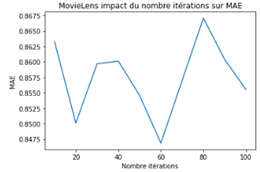

Toutefois, lorsque le code est de nouveau effectué à l’identique, avec de nouveau cette boucle sur les itérations, nous obtenons un graphe totalement différent. Certes les valeurs de MAE sont toujours comprises dans un intervalle plus ou moins identique, de 0.84 à 0.867. Par contre, le nombre d’itérations optimal n’est pas du tout identique et semble même être aléatoire. De manière arbitraire, nous avons alors choisi d’effectuer à présent 20 itérations. Ce nombre nous paraît être suffisant pour se rapprocher de la solution optimale tout en fonctionnant en un temps raisonnable.  

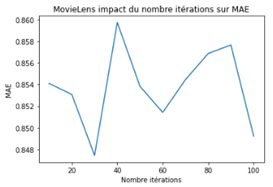

Nous avons également cherché le nombre de facteurs latents optimal avec un taux d’apprentissage égal à 0.1, un taux de décroissance à 0.7 et 20 itérations. Nous observons que le MAE croit avec le nombre de facteurs latents. Nous pouvons en déduire que plus il y a de facteurs latents, plus le modèle apprend sur base du training set. Toutefois, il apprend tellement qu’il fait de l’overfitting ou surapprentissage et modélise les bruits. Pour réduire avoir un modèle performant qui minimise l’erreur, il est alors intéressant de prendre un nombre de facteurs latents faible. Arbitrairement, nous choisissons de prendre 10 facteurs latents. 

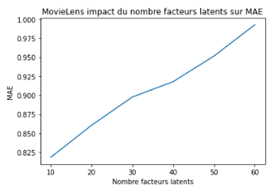

Pour résumer, nous allons implémenter ce système grâce à l’algorithme SDG sur les données MovieLens et prendre comme paramètre : 
- Terme de régularisation = 0.015 
- Taux d’apprentissage = 0.1
- Taux de décroissance = 0.7
- Nombre d’itérations = 20
- Nombre de facteurs latents = 10 


Pour les données Jester, nous avons également étudié l’impact du taux d’apprentissage et de décroissance sur le MAE avec un nombre d’itération et de facteur latents fixes et égaux à 20 tous les deux. Nous avons fait varier le taux d’apprentissage et ensuite le taux de décroissance. Il apparait que pour minimiser l’erreur de prédiction et augmenter de ce fait la performance de l’algorithme, il est intéressant de fixer des taux d’apprentissage et de décroissance respectivement égaux à 0.005 et 0.9. Nous constatons que le taux d’apprentissage est inférieur à celui choisi pour la base de données MovieLens. Les ratings de Jester sont, en effet, compris dans une plus grande échelle (-10 à 10), les erreurs sont, par conséquent, plus importantes. La mise à jour des facteurs latents doit donc se faire plus lentement. 

|| LR 0.01| LR 0.05| LR 0.1|LR 0.2|LR 0.5|
|---| --- | --- | --- |---|---|
| Decay 0.8|  | 3.61| 3.61  |||
| Decay 0.9|  3.89| 3.56| 3.78  |9.66|9.68|
| Decay 1 | | 3.89 |  | ||

<center>Tableau : Impact du taux d’apprentissage et de décroissance sur le MAE des données MovieLens<center>

De manière similaire à ce qui a été fait avec les données ratings, nous avons cherché le nombre d’itérations à implémenter. Nous avons créé une boucle pour tester l’algorithme [Code 28] au travers de 10, 20, 30, 40, 50, 60 et 70 itérations avec un taux d’apprentissage et de décroissance égaux à 0.005 et 0.9 et 20 facteurs latents. Il se trouve que réaliser la boucle à deux reprises différentes entraine des résultats différents. Le nombre d’itération optimal semble être très aléatoire et nous avons donc choisi arbitrairement de le fixer à 20 pour conserver un faible temps de calcul. 

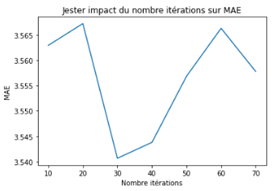

Nous avons ensuite cherché le nombre de facteurs optimal avec un taux d’apprentissage et de décroissance égaux à 0.005 et 0.9 et 20 itérations. Nous constatons que plus le nombre de facteurs latents augmente plus le modèle perd en performance et en précision. De manière similaire à ce qui a été observé sur les données MovieLens, nous pouvons supposer que l’augmentation du nombre de facteurs entraîne un surapprentissage de la base de données d’entraînement. De plus, le temps de calcul nécessaire devient de plus en plus long. Dès lors, nous choisissons de travailler avec 10 facteurs latents puisque ceux-ci permettent d’atteindre un bon niveau de performance et de conserver un temps de calcul faible.

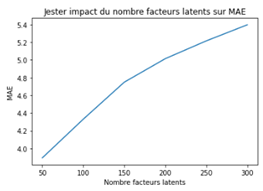

Pour résumer, nous implémenterons ce modèle sur les données Jester et prendrons comme paramètre : 
- Terme de régularisation = 0.015
- Taux d’apprentissage = 0.005
- Taux de décroissance = 0.9
- Nombre d’itérations = 20
- Nombre de facteurs latents = 10 

Nous sommes conscients que le choix des paramètres n’est pas optimal. Toutefois, le but du projet ne résidant pas dans l’optimisation des algorithmes, nous n’avons pas déployé de moyens de calcul importants. Le choix des paramètres pourrait être améliorés en testant un plus grand nombre de possibilités. Nous noterons, également, que l’initialisation des matrices de facteurs latents peuvent amener de légères variations dans les résultats obtenus. Cependant, celle-ci sont initialisées par des valeurs de la loi normale centrée et réduite et devraient, pour un grand nombre de facteurs latents, se compenser. 

# 5 EVALUATION DES SYSTEME : FOCUS SUR LES PREDICTIONS

Pour évaluer nos systèmes de recommandation, nous allons utiliser différentes mesures. 
- L’erreur moyenne absolue, appelée en anglais Means Absolute Error (MAE), est la somme des erreurs absolues de prédiction sur le nombre de prédiction total R : 
$$ mae = \frac{1}{n}\sum_{i=1}^{n}|y_i - \hat{y_i}| $$

- L’erreur quadratique moyenne, en anglais Mean Squared Error (MSE), mesure l'erreur carrée moyenne. Ceci permet de donner plus d’importance aux erreurs plus grandes qu’au plus petites. Cette mesure est toutefois moins utilisée et moins intuitive.
$$ mse = \frac{1}{n}\sum_{i=1}^{n}(y_{i} - \hat{y_i})^{2} $$

-Le Root Mean Squared Error (RMSE) est obtenu en calculant la racine carrée du MSE. Cette mesure est très largement utilisée et permet d'interpréter les résultats plus facilement.
$$ rmse = \sqrt{\frac{1}{n}\sum_{i=1}^{n}(y_{i} - \hat{y_i})^{2}} $$

L’évaluation de la factorisation matricielle, au travers du MAE, MSE et RMSE, s’est effectuée grâce à l’erreur de prédiction. Cette dernière a été calculée comme la différence entre la prédiction du modèle et le rating effectivement donné par l’utilisateur à l’item en question dans le test set. 


In [28]:
####### Code 29

def evaluation_matrix_factorization(testset,rowFactors, columnFactors):
    biais = np.mean(trainset, axis=0)[2]
    actualError= []
    MAE=0
    MSE=0
    RMSE=0
    compteur=0
    maxValue= max(testset["rating"]) 
    minValue= min(testset["rating"]) 

    for j in range (testset.shape[0]): 
        rowIndice = testset.iloc[j,0] 
        columnIndice = testset.iloc[j,1] 

        prediction = biais + rowFactors[rowIndice-1,:].dot(np.transpose(columnFactors[columnIndice-1,:])) 
        if (prediction > maxValue) :
            prediction = maxValue
        elif (prediction < minValue) :
            prediction = minValue

        theoreticalValue =testset.iloc[j,2] 
        actualError.append(abs(prediction - theoreticalValue))
        MSE=MSE+ (actualError[compteur])**2 ## a la fin c'est come une sommes des erreurs au carré
        compteur = compteur +1

    MSE=MSE/compteur
    RMSE = math.sqrt(MSE)
    MAE=np.mean(actualError)   
    return MAE,MSE,RMSE;

Dans les 4 prochaines cellules de codes, nous allons directement calculer le score prédit grâce à nos différentes approches. Nous allons ensuite mesurer l’erreur, définie comme étant la différence entre le score prédit par nos systèmes et le « vrai » rating attribué par l’utilisateur dans le test set. 
Pour les formules du collaborative filtering, nous avons utilisé la formule de score suivante : 
$$S(u,i)=\bar{r_{u}}+\frac{\sum (r_{vi}-\bar{r_{v}})w_{uv}}{\sum w_{uv} }$$

Pour le CF user-based, nous avons pris pour chaque échantillon du test set, le userId et l’itemId. Nous avons ensuite regardé si les plus proches voisins définis plus haut ont également noté ce même item. Si oui, alors nous prenons en compte la note que ce voisin a donné à cet item et la similarité entre les 2 users.
Nous devons appliquer un raisonnement similaire avec le CF item-based

Il est important de préciser que nous avons effectué un filtrage collaboratif dit user-based sur MovieLens et item-based sur Jester. En effet, il nous semblait plus pertinent d’étudier les similarités entre les utilisateurs de MovieLens qui possèdent un nombre très important d’items plutôt que l’inverse. La base de données Jester possède quant à elle plus d’utilisateurs et se prête donc mieux à un système dit item-based. 


In [29]:
####### Code 30

def Predict_MAE_RMSE_CFuser(data):
    mae_tot=0
    rmse_tot=0
    mse_tot=0
    for i in range(len(testset)):  #len(data)
        user=int(data.iloc[i][0])
        item=int(data.iloc[i][1])
        mae=0
        mse=0
        rmse=0
        impact_num=0
        impact_den=0
        pf=data_matrix.columns.get_loc(item)
        for z in range (300):
            user2=int(df[user-1][z])
            if data_matrix.iloc[user2-1,pf]==0:
                continue
            else:
                poids=cosine_full[user-1][user2-1]
                ratinguser2=data_matrix.iloc[user2-1,pf]
                impact_num=impact_num+((ratinguser2-mean_users[user2-1])*poids)
                impact_den=impact_den+(poids)
        if impact_den==0:
            impact_den=1
        score=mean_users[user-1]+(impact_num/impact_den)
        mae=abs(score-data.iloc[i][2])
        rmse=(score-data.iloc[i][2])**2
        mae_tot=mae_tot+mae
        rmse_tot=rmse_tot+rmse
    mae_final=mae_tot/len(testset)#len(data)
    mse_final= (rmse_tot/len(testset))#
    rmse_final=math.sqrt(rmse_tot/len(testset))#(len(testset))
    return mae_final,mse_final,rmse_final;

In [30]:
####### Code 31

def Predict_MAE_RMSE_CFitem(data):
    mae_tot=0
    mse_tot=0
    rmse_tot=0
    for i in range(len(data)):  #len(data)
        user=int(data.iloc[i][0])
        item=int(data.iloc[i][1])
        #print(item)
        mae=0
        mse=0
        rmse=0
        impact_num=0
        impact_den=0
        pf=data_matrix.index.get_loc(user) #index+user
        for z in range (136):
            item2=int(df[item-1][z])
            if data_matrix.iloc[pf,item2]==0:
                continue
            else:
                poids=cosine_full[item-1][item2-1]
                ratingitem2=int(data_matrix.iloc[pf,item2])
                impact_num=impact_num+((ratingitem2-mean_items[item2-1])*poids)
                impact_den=impact_den+(poids)
        if impact_den==0:
            impact_den=1
        score=mean_items[item-1]+(impact_num/impact_den)
        mae=abs(score-data.iloc[i][2])
        rmse=(score-data.iloc[i][2])**2
        mae_tot=mae_tot+mae
        rmse_tot=rmse_tot+rmse
    mae_final=mae_tot/len(data)
    mse_final=rmse_tot/len(data)
    rmse_final=math.sqrt(rmse_tot/len(data))#(len(testset))
    return mae_final,mse_final,rmse_final;

Pour les prédictions de score selon la moyenne, nous avons simplement pris la moyenne (moyenne générale, moyenne user ou moyenne item), que nous avons soustrait à la valeur du rating du test set.

In [31]:
####### Code 32

def Prediction_MAE_RMSE_Moyenne_User(data):
    mae=0
    mse=0
    rmse=0
    for i in range(len(testset)):
        user=int(data.iloc[i][0]-1)
        #print("nous sommes à la recherche du userId: "+str(user))
        mae=mae+abs(mean_users[user]-data.iloc[i][2])
        rmse=rmse+(mean_users[user]-data.iloc[i][2])**2
    mae_final=mae/(len(data))
    mse_final=(rmse/len(data))
    rmse_final=math.sqrt(rmse/len(data))
    return mae_final,mse_final,rmse_final;

In [32]:
####### Code 33

def Prediction_MAE_RMSE_Moyenne_Item(data):
    mae_tot=0
    mse_tot=0
    rmse_tot=0
    mae=0
    mse=0
    rmse=0
    for i in range(len(testset)):
        item=int(data.iloc[i][1]-1)
        #print("nous sommes à la recherche du userId: "+str(user))
        mae=mae+abs(mean_items[item]-data.iloc[i][2])
        rmse=rmse+(mean_items[item]-data.iloc[i][2])**2
    mae_final=mae/(len(data))
    mse_final=rmse/len(data)
    rmse_final=math.sqrt(rmse/len(data))
    return mae_final,mse_final,rmse_final;

In [33]:
####### Code 34

def Prediction_MAE_RMSE_Moyenne(data):
    mae=0
    mse=0
    rmse=0
    for i in range(len(testset)):
        mae=mae+abs((mean-data.iloc[i][2]))
        rmse=rmse+(mean-data.iloc[i][2])**2
    mae_final=mae/(len(data))
    mse_final=rmse/len(data)
    rmse_final=math.sqrt(rmse/len(data))
    return mae_final,mse_final,rmse_final;

# 6. Lancement des différents systèmes de recommandations avec une cross validation 

Dans la cellule suivante [Code 35], se trouve l’initialisation des vecteurs et tableaux qui vont servir à stocker les mesures d'évaluation de nos systèmes. Le code 36 permet quant à lui de compléter les listes et les tableaux présentés dans le code 37.

In [34]:
####### Code 35 : Création des vecteurs pour stocker les valeurs des mesures d'évaluations

cumulative_MAE_Mean=[]
cumulative_MSE_Mean=[]
cumulative_RMSE_Mean=[]

cumulative_MAE_MeanUser=[]
cumulative_MSE_MeanUser=[]
cumulative_RMSE_MeanUser=[]

cumulative_MAE_MeanItem=[]
cumulative_MSE_MeanItem=[]
cumulative_RMSE_MeanItem=[]

cumulative_MAE_CF=[]
cumulative_MSE_CF=[]
cumulative_RMSE_CF=[]

cumulative_MAE_Facto=[]
cumulative_MSE_Facto=[]
cumulative_RMSE_Facto=[]

results_Mean = [{'MAE': 0, 'MSE': 0, 'RMSE': 0},
              {'MAE': 0, 'MSE': 0, 'RMSE': 0},
              {'MAE': 0, 'MSE': 0, 'RMSE': 0 },
              {'MAE': 0, 'MSE': 0, 'RMSE': 0 },
              {'MAE': 0, 'MSE': 0, 'RMSE': 0 }]
results_MeanUser = [{'MAE': 0, 'MSE': 0, 'RMSE': 0},
              {'MAE': 0, 'MSE': 0, 'RMSE': 0},
              {'MAE': 0, 'MSE': 0, 'RMSE': 0 },
              {'MAE': 0, 'MSE': 0, 'RMSE': 0 },
              {'MAE': 0, 'MSE': 0, 'RMSE': 0 }]
results_MeanItem = [{'MAE': 0, 'MSE': 0, 'RMSE': 0},
              {'MAE': 0, 'MSE': 0, 'RMSE': 0},
              {'MAE': 0, 'MSE': 0, 'RMSE': 0 },
              {'MAE': 0, 'MSE': 0, 'RMSE': 0 },
              {'MAE': 0, 'MSE': 0, 'RMSE': 0 }]
results_CF = [{'MAE': 0, 'MSE': 0, 'RMSE': 0},
              {'MAE': 0, 'MSE': 0, 'RMSE': 0},
              {'MAE': 0, 'MSE': 0, 'RMSE': 0 },
              {'MAE': 0, 'MSE': 0, 'RMSE': 0 },
              {'MAE': 0, 'MSE': 0, 'RMSE': 0 }]
results_Facto = [{'MAE': 0, 'MSE': 0, 'RMSE': 0},
              {'MAE': 0, 'MSE': 0, 'RMSE': 0},
              {'MAE': 0, 'MSE': 0, 'RMSE': 0 },
              {'MAE': 0, 'MSE': 0, 'RMSE': 0 },
              {'MAE': 0, 'MSE': 0, 'RMSE': 0 }]
res_M = pd.DataFrame(results_Mean)
res_CF = pd.DataFrame(results_CF)
res_MU = pd.DataFrame(results_MeanUser)
res_MI= pd.DataFrame(results_MeanItem)
res_Fact = pd.DataFrame(results_Facto)

In [35]:
####### Code 36 : Remplissage des vecteurs apès chaque boucle de la cross-validation

def Fill_in_vectors():
    cumulative_MAE_Mean.append(maeAvg)
    cumulative_MSE_Mean.append(mseAvg)
    cumulative_RMSE_Mean.append(rmseAvg)
    
        
    cumulative_MAE_MeanUser.append(maeMuser)
    cumulative_MSE_MeanUser.append(mseMuser)
    cumulative_RMSE_MeanUser.append(rmseMuser)
    
    cumulative_MAE_MeanItem.append(maeMitem)
    cumulative_MSE_MeanItem.append(mseMitem)
    cumulative_RMSE_MeanItem.append(rmseMitem)
    
    cumulative_MAE_CF.append(mae)
    cumulative_MSE_CF.append(mse)
    cumulative_RMSE_CF.append(rmse)
  
    cumulative_MAE_Facto.append(maeFM)
    cumulative_MSE_Facto.append(mseFM)
    cumulative_RMSE_Facto.append(rmseFM)
    
    res_M.iloc[z-1,0] =maeAvg
    res_M.iloc[z-1,1] =mseAvg
    res_M.iloc[z-1,2] =rmseAvg
    
    res_CF.iloc[z-1,0] =mae
    res_CF.iloc[z-1,1] =mse
    res_CF.iloc[z-1,2] =rmse
    
    res_MU.iloc[z-1,0] =maeMuser
    res_MU.iloc[z-1,1] =mseMuser
    res_MU.iloc[z-1,2] =rmseMuser
    
    res_MI.iloc[z-1,0] =maeMitem
    res_MI.iloc[z-1,1] =mseMitem
    res_MI.iloc[z-1,2] =rmseMitem
    
    res_Fact.iloc[z-1,0] =maeFM
    res_Fact.iloc[z-1,1] =mseFM
    res_Fact.iloc[z-1,2] =rmseFM

Cette cellule permet d’imprimer le résultat des évaluations des systèmes de recommandation utilisés. 

In [36]:
######## Code 37 : affichage des valeurs des mesures d'évaluations

def Information_printed():
    print(" \nRésultats de l'évaluations des sytèmes basées sur moyenne pour les 5 phases(fold) de la cross-validation: ")
    print()
    print(res_M)
    print("\nle MAE moyen du sytème moyenne après une cross-validation: "+str(statistics.mean(cumulative_MAE_Mean)))
    print("le MSE moyen du sytème moyenne après une cross-validation: "+str(statistics.mean(cumulative_MSE_Mean)))
    print("le RMSE moyen du sytème moyenne après une cross-validation: "+str(statistics.mean(cumulative_RMSE_Mean)))
    print("-----------------")
    print(" \nRésultats de l'évaluations des sytèmes basées sur moyenne utilisateurs pour les 5 phases(fold) de la cross-validation: ")
    print()
    print(res_MU)
    print("\nle MAE moyen du sytème moyenne utilisateurs après une cross-validation: "+str(statistics.mean(cumulative_MAE_MeanUser)))
    print("le MSE moyen du sytème moyenne utilisateurs après une cross-validation: "+str(statistics.mean(cumulative_MSE_MeanUser)))
    print("le RMSE moyen du sytème moyenne utilisateurs après une cross-validation: "+str(statistics.mean(cumulative_RMSE_MeanUser)))
    print("-----------------")
    print(" \nRésultats de l'évaluations des sytèmes basées sur moyenne items pour les 5 phases(fold) de la cross-validation: ")
    print()
    print(res_MI)
    print("\nle MAE moyen du sytème moyenne items après une cross-validation: "+str(statistics.mean(cumulative_MAE_MeanItem)))
    print("le MSE moyen du sytème moyenne items après une cross-validation: "+str(statistics.mean(cumulative_MSE_MeanItem)))
    print("le RMSE moyen du sytème moyenne items après une cross-validation: "+str(statistics.mean(cumulative_RMSE_MeanItem)))
    print("-----------------")
    print(" \nRésultats de l'évaluations des sytèmes basées sur filtrage collaboratif pour les 5 phases(fold) de la cross-validation: ")
    print()
    print(res_CF)
    print("\nle MAE moyen du sytème filtrage collaboratif après une cross-validation: "+str(statistics.mean(cumulative_MAE_CF)))
    print("le MSE moyen du sytème filtrage collaboratif après une cross-validation: "+str(statistics.mean(cumulative_MSE_CF)))
    print("le RMSE moyen du sytème filtrage collaboratif après une cross-validation: "+str(statistics.mean(cumulative_RMSE_CF)))
    print("-----------------")
    print(" \nRésultats de l'évaluations des sytèmes basées sur factorization pour les 5 phases(fold) de la cross-validation: ")
    print()
    print(res_Fact)
    print("\nle MAE moyen du sytème factorization après une cross-validation: "+str(statistics.mean(cumulative_MAE_Facto)))
    print("le MSE moyen du sytème factorization après une cross-validation: "+str(statistics.mean(cumulative_MSE_Facto)))
    print("le RMSE moyen du sytème factorization après une cross-validation: "+str(statistics.mean(cumulative_RMSE_Facto)))

Enfin, le code ci-dessous [Code 38] permet d’utiliser les systèmes de recommandations définis précédemment sur les bases de données Jester ou MovieLens et de les évaluer grâce à la cross-validation 5-fold présentée plus haut. 

Pour la cross-validation [code 38], nous avons choisi de mesurer les similarités via cosine. La similarité selon Pearson sera placeé juste en dessous de la ligne de code mesurant le cosine et celle-ci est indiquée en tant que commentaire. Si vous voulez utiliser Pearson, vous devrez retirer le commentaire à la ligne de Pearson et mettre la fonction cosine en commentaire.

In [37]:
######### Code 38 : Boucle effetuant la cross-validation

folds=[1,2,3,4,5]

for z in folds:
    print("----")
    print("Chargement de la cross-validation n° "+str(z))
    
    trainset=Choose_trainset(z) 
    testset=Choose_testset(z)
    trainset=Add_squareratingCol(trainset)
    mean=Mean_rating(trainset)
    mean_users=Mean_user(trainset)
    mean_items=Mean_item(trainset)
    if choice_dataset==1:
        rating_pivoteds=Rating_pivoted(trainset)
        dd=rating_pivoteds.shape
        col=dd[1] #number of columns
        row=dd[0]
        cosine_full = 1 - pairwise_distances( rating_pivoteds.values, metric="cosine" )
        #cosine_full=Pearson_library(rating_pivoteds)    # sI ON VEUT FAIRE LES SIMILARITES AVEC PEARSON
        for i in range(cosine_full.shape[0]):
            cosine_full[i][i]=0
        dg=Cosine_full_sorted(cosine_full)
        df=Top_n_neighbo(dg)
        mae,mse,rmse=Predict_MAE_RMSE_CFuser(testset)
        maeMuser,mseMuser,rmseMuser=Prediction_MAE_RMSE_Moyenne_User(testset)
        maeMitem,mseMitem,rmseMitem=Prediction_MAE_RMSE_Moyenne_Item(testset)
        maeAvg,mseAvg,rmseAvg=Prediction_MAE_RMSE_Moyenne(testset)
         
        numIterations =20
        learnRate = 0.1
        decay = 0.7 # décroissance learnRate, si = 1 décroit pas
        lambd = 0.015
        numFactors = 10 # nombre de facteur latent 
        rowFactors, columnFactors=matrix_factorization (trainset,learnRate,decay,numIterations, lambd, numFactors)
        maeFM, mseFM, rmseFM = evaluation_matrix_factorization(testset,rowFactors,columnFactors)

    if choice_dataset==2:
        rating_pivoteds=Rating_pivoted_transposed(trainset)
        dd=rating_pivoteds.shape
        col=dd[1] #number of columns
        row=dd[0]
        cosine_full = 1 - pairwise_distances( rating_pivoteds.values, metric="cosine" )
        #cosine_full=Pearson_library(rating_pivoteds)
        for i in range(cosine_full.shape[0]):
            cosine_full[i][i]=0
        dg=Cosine_full_sorted(cosine_full)
        df=Top_n_neighbo(dg)
        mae,mse,rmse=Predict_MAE_RMSE_CFitem(testset)
        maeMuser,mseMuser,rmseMuser=Prediction_MAE_RMSE_Moyenne_User(testset)
        maeMitem,mseMitem,rmseMitem=Prediction_MAE_RMSE_Moyenne_Item(testset)
        maeAvg,mseAvg,rmseAvg=Prediction_MAE_RMSE_Moyenne(testset)
        
        numIterations =20
        learnRate = 0.005
        decay = 0.9 # décroissance learnRate, si = 1 décroit pas
        lambd = 0.015
        numFactors = 10 # nombre de facteur latent 
        rowFactors, columnFactors=matrix_factorization (trainset,learnRate,decay,numIterations, lambd, numFactors)
        maeFM, mseFM, rmseFM = evaluation_matrix_factorization(testset,rowFactors,columnFactors)
        
    Fill_in_vectors()
print("-------")
Information_printed()

----
Chargement de la cross-validation n° 1
----
Chargement de la cross-validation n° 2
----
Chargement de la cross-validation n° 3
----
Chargement de la cross-validation n° 4
----
Chargement de la cross-validation n° 5
-------
 
Résultats de l'évaluations des sytèmes basées sur moyenne pour les 5 phases(fold) de la cross-validation: 

        MAE        MSE      RMSE
0  3.812350  24.882723  4.988259
1  3.816009  24.950083  4.995006
2  3.797644  24.770821  4.977029
3  3.810209  24.858874  4.985867
4  3.794026  24.661453  4.966030

le MAE moyen du sytème moyenne après une cross-validation: 3.806047771315068
le MSE moyen du sytème moyenne après une cross-validation: 24.82479071038995
le RMSE moyen du sytème moyenne après une cross-validation: 4.982438187948519
-----------------
 
Résultats de l'évaluations des sytèmes basées sur moyenne utilisateurs pour les 5 phases(fold) de la cross-validation: 

        MAE        MSE      RMSE
0  3.369517  20.785918  4.559158
1  3.387703  21.006643  

Nous obtenons une évaluation des 4 systèmes de recommandations grâce aux mesures choisies. Les tableaux d’évaluations du système de moyenne générale, moyenne utilisateur ou item, filtrage collaboratif dit user-based ou item-based (en fonction de la base de données choisi) et factorisation de matrice recense les mesures pour chaque étape de la cross-validation 5 fold. Enfin, pour chaque mesure et chaque système, nous calculons une moyenne. Cette dernière va être utilisée pour la comparaison des différents systèmes.

# 7. Comparaison des systèmes

Ensuite, nous avons créé un tableau récapitulatif permettant de synthétiser l’évaluation de chacun des systèmes au travers des différentes mesures [Code 39].  

In [38]:
####### Code 39 : Synthèse de l'efficacité de chaque approche 

Mean_MAE_Mean = statistics.mean(cumulative_MAE_Mean)
Mean_MSE_Mean = statistics.mean(cumulative_MSE_Mean)
Mean_RMSE_Mean = statistics.mean(cumulative_RMSE_Mean)

Mean_MAE_MeanU = statistics.mean(cumulative_MAE_MeanUser)
Mean_MSE_MeanU = statistics.mean(cumulative_MSE_MeanUser)
Mean_RMSE_MeanU = statistics.mean(cumulative_RMSE_MeanUser)

Mean_MAE_MeanI = statistics.mean(cumulative_MAE_MeanItem)
Mean_MSE_MeanI = statistics.mean(cumulative_MSE_MeanItem)
Mean_RMSE_MeanI = statistics.mean(cumulative_RMSE_MeanItem)

Mean_MAE_CF = statistics.mean(cumulative_MAE_CF)
Mean_MSE_CF = statistics.mean(cumulative_MSE_CF)
Mean_RMSE_CF = statistics.mean(cumulative_RMSE_CF)

Mean_MAE_Facto = statistics.mean(cumulative_MAE_Facto)
Mean_MSE_Facto = statistics.mean(cumulative_MSE_Facto)
Mean_RMSE_Facto = statistics.mean(cumulative_RMSE_Facto)

result_all_sys = [{'MAE':Mean_MAE_Mean , 'MSE': Mean_MSE_Mean, 'RMSE': Mean_RMSE_Mean}, ### système 0 MEAN
          {'MAE': Mean_MAE_MeanU, 'MSE': Mean_MSE_MeanU, 'RMSE': Mean_RMSE_MeanU},
          {'MAE': Mean_MAE_MeanI, 'MSE': Mean_MSE_MeanI, 'RMSE': Mean_RMSE_MeanI},### système Mean U
          {'MAE': Mean_MAE_CF, 'MSE': Mean_MSE_CF, 'RMSE': Mean_RMSE_CF},
          {'MAE': Mean_MAE_Facto, 'MSE': Mean_MSE_Facto, 'RMSE': Mean_RMSE_Facto }]
res = pd.DataFrame(result_all_sys)
res=res.rename(index={0:'Moyenne Générale',1:'Moyenne User',2:'Moyenne Item',3:'Collaborative Filtering',4:'Matrix Factorization'})
res

,MAE,MSE,RMSE
Moyenne Générale,3.806048,24.824791,4.982438
Moyenne User,3.381692,20.890834,4.570605
Moyenne Item,3.748067,23.599972,4.857969
Collaborative Filtering,3.297736,19.532601,4.419533
Matrix Factorization,3.472732,20.865043,4.567799


Pour éviter de devoir faire tourner tout le code deux fois afin d’obtenir l’évaluations des systèmes au travers des bases de données, nous avons résumé les résultats ci-dessous. Ces matrices sont constituées de la même façon que celle présentée précédemment.  

<h3><center>MovieLens <center><h3>

|Metrics| MAE | MSE | RMSE |
|---| --- | --- | --- |
|Moyenne Générale| 0.850  | 1.119  | 1.058  |
|Moyenne User| 0.750  | 0.927 |0.963  |
|Moyenne Item| 0.773 | 0.993 | 0.996|
| User-based Collaborative Filtering- Cosine|  0.693 |0.824  | 0.908 |
| User-based Collaborative Filtering- Pearson|  0.698 |0.836  |0.914  |
|Matrix factorization| 0.811| 1.139| 1.067 | 

<h3><center>Jester <center><h3>

|Metrics| MAE | MSE | RMSE |
|---| --- | --- | --- |
|Moyenne Générale| 3.838  | 25.659 | 5.063  |
|Moyenne User| 3.379 |20.861  |4.567 |
|Moyenne Item|  3.778 | 24.415 |  4.940 |
| Item-based Collaborative Filtering- Cosine| 3.325  | 20.208  | 4.486 |
| Item-based Collaborative Filtering- Pearson|  3.327  | 20.208  | 4.495  |
|Matrix factorization| 3.479 | 21.002 |4.583  | 


Dans cette section, nous allons passer en revue les différents systèmes effectués, discuter de leur efficacité de manière générale et plus précisément sur l'une ou l'autre base de données. Enfin, nous ajouterons quelques remarques spécifiques à la base de données Jester. 

Certaines approches implémentées sont très naïves, comme celle visant à prédire chaque rating en tant que moyenne globale de tous les ratings. Cependant, les résultats fournis ne sont pas insatisfaisants étant donné la simplicité du processus et le temps de calcul. Si nous voulons être un peu plus précis, alors nous allons prendre en compte la moyenne de l’utilisateur (ou de l’item) et nous prédirons qu’il attribuera toujours une note similaire à sa moyenne. 

Dans les methodes des moyennes faites sur les données MovieLens, nous remarquons que les moyennes sur les utilisateurs sont légèrement meilleures que les moyennes sur les items. En effet, un MAE petit signifie que l'erreur entre la prédiction du modèle et la vraie note donnée par l'utilisateur est faible. Pour avoir un modèle performant, qui réalise de bonnes rédictions, il est intéressant de minimiser cette erreur et donc la valeur du MAE (ou du MSE et RMSE). Les moyennes des items sont probablement moins bonnes car nou possédons netement moins d'informations sur chaque item que sur chaque utilisateurs. En effet, certains items ne possèdaient qu'un seul rating dans le train set et il est donc difficile de déduire une moyenne fiable.

Concernant les systèmes de moyennes sur Jester, nous remarquons étonnement que les résulats des moyennes sur les utilisateurs sont meilleurs que ceux des items. Cela pourrait être dû à une erreur de notre part dans l'implémentation des prédictions. Une autre explication à cela pourrait être que les utilisateurs ont souvent tendance à donner les mêmes ratings et ceux-ci ne varient donc pas fortement. Néanmoins, certaines blagues peuvent être fortement appréciées par certains utilisateurs et détestées par d'autres, ce qui causerait une grande variance pour la moyenne des blagues et expliquerait donc cette moins bonne prédiction.

Ensuite, le filtrage collaboratif permet de prendre en compte l’avis des voisins de l’item ou l’objet étudié. L’idée en arrière-plan consiste à prétendre, par exemple, que je suis potentiellement enclin à aimer de nouveaux produits qu’un utilisateur qui m’est similaire a aimé. Dans ce même exemple, le calcul de la prédiction d’un item accordera un poids plus important aux utilisateurs qui ont déjà testé ce dernier et qui ont des goûts fortement similaires aux miens. Le système de filtrages collaboratifs réalisé sur MovieLens est dit user-based et se base sur la similarité existante entre les utilisateurs. Alors que le modèle de filtrage réalisé sur Jester est de type item-based et repose sur la similarité entre items. Il tentera d’établir des similarités entre les items lorsque ceux-ci sont appréciés par les mêmes personnes. Dès lors, il sera possible de suggérer le produit ou objet à des utilisateurs qui ont apprécié des objets similaires.

On remarque que le filtrage collaboratif est plus performant que les systèmes basés sur les moyennes. Cette observation est logique étant donné qu’un rating sera très vraisemblablement plus proche de ses voisins que de la moyenne. Les prédictions faites pour le filtrage collaboratif sont alors plus proches de la réalité et ont moins de chance de se tromper. Nous supposons également que le filtrage collaboratif user-based sur Jester et item-based pour MovieLens aura tendance à apporter de moins bons résultats étant donné que la matrice de similarité sera beaucoup plus grande et créée avec peu d'informations.

Finalement, la factorisation de matrice est un algorithme un peu plus lourd à implémenter mais qui peut s’avérer assez performant. Pour l’améliorer, il est possible d’ajouter des facteurs additionnels. Il peut s’agir par exemple du biais de chaque utilisateur et de chaque item. En effet, certains utilisateurs délivrent toujours des ratings égaux à 3 ou 4 sur une échelle de 0 à 5. Le modèle peut être modifié aussi pour y incorporer les feedbacks implicites ou les ratings du voisinage. Nous pensons qu’ajouter des termes additionnels pourrait améliorer la performance de ce système. 

Concernant la base de données Jester de manière générale, nous pouvons noter que les résultats des mesures d'évaluations sont beaucoup plus élevées que ceux de MovieLens. Nous supposons que cela est principalement dû au fait que l'intervalle des ratings est beacoup plus grand. Les utilsateurs de Jester peuvent, en effet, noter les blagues entre +10 à -10, alors que sur MovieLens les ratings peuvent être attribués entre 0.5 et 5. Les erreurs de prédiction des systèmes de recommandations sur Jester seront proportionnellement plus grande.

Si nous revenons un instant sur MovieLens, l'erreur MAE (du filtrage collaboratif) est d'environs 15% par rapport à la vrai note :
$$\frac{0.693(MAE)}{4.5(IntervalleRating)}=15.4\%$$ 

Si nous faisons un calcul similaire avec la MAE (du filtrage collaboratif) de Jester, cela donne :
$$\frac{3.327(MAE)}{20(IntervalleRating)}=16.63\%$$

Nous pouvons donc observer que les erreurs sont finalement assez similaires entre la base de données MovieLens et la base de données Jester.


# 8. Conclusion

En conclusion, nous constatons que les sytèmes de recommandation basés sur le filtrage collaboratif sont très performants. Pour les deux bases de données, ce système détient des erreurs de prédiction plus faibles que celles des systèmes de factorisation de matrice et des moyennes. Toutefois, L'approche des moyennes, bien que très naîve produit des prédictions satisfaisantes. En ce qui concerne le système de recommandationn basé sur la factorisation matricielle, les résultats sont quelque peut décevants. Nous pensons dès lors que l'ajout de termes additionnel au modèle pourrait très fortement améliorer la performance des prédictions faites. 

# 9. Bibliographie

Goldberg, K. (2001). Jester Datasets for Recommender Systems and Collaborative Filtering Research. Retrieved from http://eigentaste.berkeley.edu/dataset/

Ivarsson J. & Lindgren M. Movie recommendations using matrix factorization. Thèse de bachelier, School of Electrical Engineering and Computer Science, Stockholm. En ligne : http://www.diva-portal.org/smash/record.jsf?pid=diva2%3A927190&dswid=-9934

Sommer, F. (2020). Sytèmes de recommandation. Document non publié, Louvain School of Management, Mons

Y. Koren, R. Bell and C. Volinsky, Matrix Factorization Techniques for Recommender Systems, in Computer, vol. 42, no. 8, pp. 30-37, Aug. 2009, doi: 10.1109/MC.2009.263. 

Y. Koren. (2008). Factorization meets the neighborhood: a multifaceted collaborative filtering model. In Proceedings of the 14th ACM SIGKDD international conference on Knowledge discovery and data mining (KDD ’08). Association for Computing Machinery, New York, NY, USA, 426–434. DOI:https://doi.org/10.1145/1401890.1401944
